Corpus Europarl

sin suavizacion:

In [12]:
import nltk
from nltk.corpus import europarl_raw
from collections import defaultdict, Counter
import random

nltk.download('europarl_raw')

europarl_sentences = europarl_raw.english.sents()

def preprocess_sentences(sentences):
    preprocessed = []
    for sentence in sentences:
        sentence = [word.lower() for word in sentence if word.isalpha()]
        preprocessed.append(sentence)
    return preprocessed

preprocessed_sentences = preprocess_sentences(europarl_sentences)

def generate_ngrams(sentence, n):
    ngrams = zip(*[sentence[i:] for i in range(n)])
    return list(ngrams)

class SimpleNgramModel:
    def __init__(self, sentences, n):
        self.n = n
        self.ngram_counts = defaultdict(Counter)
        self.unigram_counts = Counter()

        for sentence in sentences:
            sentence = ['<s>'] * (n - 1) + sentence + ['</s>']
            for i in range(1, n + 1):
                ngrams = generate_ngrams(sentence, i)
                for ngram in ngrams:
                    self.ngram_counts[i][ngram] += 1
                    if i == 1:
                        self.unigram_counts[ngram] += 1

    def get_probability(self, ngram):
        count_ngram = self.ngram_counts[len(ngram)][ngram]

        if len(ngram) == 1:
            total_count = sum(self.unigram_counts.values())
        else:
            total_count = sum(self.ngram_counts[len(ngram) - 1][ngram[:-1]] for ngram in self.ngram_counts[len(ngram) - 1])

        if total_count > 0:
            return count_ngram / total_count
        else:
            return 0

    def generate_text(self, num_words=20):
        generated_sentence = ['<s>'] * (self.n - 1)
        for _ in range(num_words):
            next_word_candidates = []
            for ngram in self.ngram_counts[self.n]:
                if ngram[:-1] == tuple(generated_sentence[-(self.n - 1):]):
                    next_word_candidates.append((ngram[-1], self.get_probability(ngram)))

            next_word_candidates.sort(key=lambda x: x[1], reverse=True)
            next_word = next_word_candidates[0][0] if next_word_candidates else '</s>'

            if next_word == '</s>':
                break
            generated_sentence.append(next_word)

        return " ".join(generated_sentence[self.n - 1:])


n = 3
simple_model = SimpleNgramModel(preprocessed_sentences[:50000], n)

simple_generated_text = simple_model.generate_text(num_words=30)
print("Texto generado sin suavización:")
print(simple_generated_text)


[nltk_data] Downloading package europarl_raw to /root/nltk_data...
[nltk_data]   Package europarl_raw is already up-to-date!


Texto generado sin suavización:
the commission s proposal to amend the directive


In [13]:
def sequence_probability(model, sequence):
    ngrams = generate_ngrams(sequence, model.n)
    total_prob = 1.0
    for ngram in ngrams:
        prob = model.get_probability(ngram)
        total_prob *= prob if prob > 0 else 1e-10
    return total_prob

Suavización de interpolacion

In [14]:
import nltk
from nltk.corpus import europarl_raw
from collections import defaultdict, Counter
import random

nltk.download('europarl_raw')

europarl_sentences = europarl_raw.english.sents()

def preprocess_sentences(sentences):
    preprocessed = []
    for sentence in sentences:
        sentence = [word.lower() for word in sentence if word.isalpha()]
        preprocessed.append(sentence)
    return preprocessed

preprocessed_sentences = preprocess_sentences(europarl_sentences)

def generate_ngrams(sentence, n):
    ngrams = zip(*[sentence[i:] for i in range(n)])
    return list(ngrams)

class InterpolatedNgramModel:
    def __init__(self, sentences, n, lambdas=None):
        self.n = n
        self.lambdas = lambdas if lambdas else [1/n] * n
        self.ngram_counts = defaultdict(Counter)
        self.unigram_counts = Counter()

        for sentence in sentences:
            sentence = ['<s>'] * (n - 1) + sentence + ['</s>']
            for i in range(1, n + 1):
                ngrams = generate_ngrams(sentence, i)
                for ngram in ngrams:
                    self.ngram_counts[i][ngram] += 1
                    if i == 1:
                        self.unigram_counts[ngram] += 1

    def get_probability(self, ngram):
        total_prob = 0
        for i in range(1, len(ngram) + 1):
            lambda_weight = self.lambdas[i - 1]
            prefix = tuple(ngram[-i:])
            if i == 1:
                count_ngram = self.unigram_counts[prefix]
                total_count = sum(self.unigram_counts.values())
            else:
                count_ngram = self.ngram_counts[i][prefix]
                total_count = sum(self.ngram_counts[i-1][prefix[:-1]] for prefix in self.ngram_counts[i-1])

            prob_ngram = count_ngram / total_count if total_count > 0 else 0
            total_prob += lambda_weight * prob_ngram
        return total_prob

    def generate_text(self, num_words=20):
        generated_sentence = ['<s>'] * (self.n - 1)
        for _ in range(num_words):
            next_word_candidates = []
            for ngram in self.ngram_counts[self.n]:
                if ngram[:-1] == tuple(generated_sentence[-(self.n - 1):]):
                    next_word_candidates.append((ngram[-1], self.get_probability(ngram)))

            next_word_candidates.sort(key=lambda x: x[1], reverse=True)
            next_word = next_word_candidates[0][0] if next_word_candidates else '</s>'

            if next_word == '</s>':
                break
            generated_sentence.append(next_word)

        return " ".join(generated_sentence[self.n - 1:])

n = 3
model = InterpolatedNgramModel(preprocessed_sentences[:50000], n, lambdas=[0.1, 0.3, 0.6])

generated_text = model.generate_text(num_words=30)
print("Texto generado:")
print(generated_text)


[nltk_data] Downloading package europarl_raw to /root/nltk_data...
[nltk_data]   Package europarl_raw is already up-to-date!


Texto generado:
the of the the commission the for the of the the commission the for the of the the commission the for the of the the commission the for the of


Las probabilidades son: [4.998163050349343e-11, 4.6497153861473555e-24]


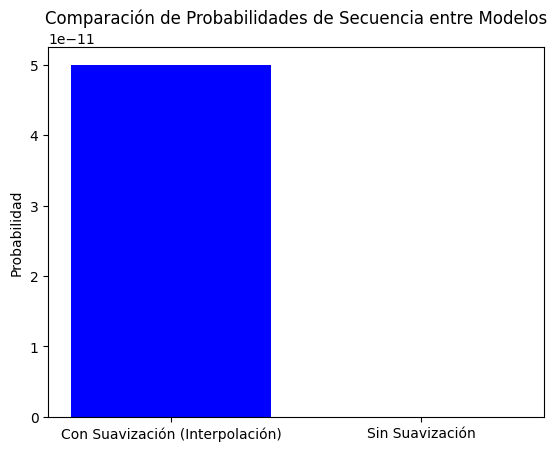

In [15]:
import matplotlib.pyplot as plt

test_sequence = ['the', 'european', 'parliament', 'is', 'important']

interpolated_prob = sequence_probability(model, test_sequence)

simple_prob = sequence_probability(simple_model, test_sequence)

models = ['Con Suavización (Interpolación)', 'Sin Suavización']
probabilities = [interpolated_prob, simple_prob]
print(f"Las probabilidades son: {probabilities}")
plt.bar(models, probabilities, color=['blue', 'green'])
plt.title('Comparación de Probabilidades de Secuencia entre Modelos')
plt.ylabel('Probabilidad')
plt.show()

Suavizado Backoff

In [ ]:
import nltk
from nltk.corpus import europarl_raw
from collections import defaultdict, Counter
import random

nltk.download('europarl_raw')

europarl_sentences = europarl_raw.english.sents()

def preprocess_sentences(sentences):
    preprocessed = []
    for sentence in sentences:
        sentence = [word.lower() for word in sentence if word.isalpha()]
        preprocessed.append(sentence)
    return preprocessed

preprocessed_sentences = preprocess_sentences(europarl_sentences)

def generate_ngrams(sentence, n):
    ngrams = zip(*[sentence[i:] for i in range(n)])
    return list(ngrams)

class BackoffNgramModel:
    def __init__(self, sentences, n):
        self.n = n
        self.ngram_counts = defaultdict(Counter)
        self.unigram_counts = Counter()

        for sentence in sentences:
            sentence = ['<s>'] * (n - 1) + sentence + ['</s>']
            for i in range(1, n + 1):
                ngrams = generate_ngrams(sentence, i)
                for ngram in ngrams:
                    self.ngram_counts[i][ngram] += 1
                    if i == 1:
                        self.unigram_counts[ngram] += 1

    def get_probability(self, ngram):
        for i in range(len(ngram), 0, -1):
            prefix = tuple(ngram[-i:])
            count_ngram = self.ngram_counts[i][prefix]

            if i > 1:
                total_count = sum(self.ngram_counts[i-1][prefix[:-1]] for prefix in self.ngram_counts[i-1])
            else:
                total_count = sum(self.unigram_counts.values())

            if count_ngram > 0 and total_count > 0:
                return count_ngram / total_count

        return 1e-7

    def generate_text(self, num_words=20):
        generated_sentence = ['<s>'] * (self.n - 1)
        for _ in range(num_words):
            next_word_candidates = []
            for ngram in self.ngram_counts[self.n]:
                if ngram[:-1] == tuple(generated_sentence[-(self.n - 1):]):
                    next_word_candidates.append((ngram[-1], self.get_probability(ngram)))

            next_word_candidates.sort(key=lambda x: x[1], reverse=True)
            next_word = next_word_candidates[0][0] if next_word_candidates else '</s>'

            if next_word == '</s>':
                break
            generated_sentence.append(next_word)

        return " ".join(generated_sentence[self.n - 1:])

n = 3
model = BackoffNgramModel(preprocessed_sentences[:50000], n)

generated_text = model.generate_text(num_words=30)
print("Texto generado:")
print(generated_text)


[nltk_data] Downloading package europarl_raw to /root/nltk_data...
[nltk_data]   Package europarl_raw is already up-to-date!


In [ ]:
import matplotlib.pyplot as plt

test_sequence = ['the', 'european', 'parliament', 'is', 'important']

interpolated_prob = sequence_probability(model, test_sequence)

simple_prob = sequence_probability(simple_model, test_sequence)

models = ['Con Suavización (Backoff)', 'Sin Suavización']
probabilities = [interpolated_prob, simple_prob]
print(f"Las probabilidades son: {probabilities}")
plt.bar(models, probabilities, color=['blue', 'green'])
plt.title('Comparación de Probabilidades de Secuencia entre Modelos')
plt.ylabel('Probabilidad')
plt.show()